<a href="https://colab.research.google.com/github/silviolima07/Clusters/blob/main/Solar_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing, cluster
import yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


%matplotlib inline


In [44]:
def hist_plot(df,var,bins=20):
  return df.hist(column = var, figsize=(7,6), bins=bins);

In [45]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [46]:
def number_of_cluster(coluna):
  sse={}
  df_cluster = df[[coluna]]
  for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
  plt.figure(figsize=(10, 5))
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.title("Number of Cluster by Column\n"+coluna)
  plt.xlabel("Number of cluster")
  plt.show()

In [47]:
def create_cluster(df,coluna, nova_coluna):
  #building 3 clusters for Frequency and adding it to dataframe
  kmeans = KMeans(n_clusters=3)
  kmeans.fit(df[[coluna]])
  df[nova_coluna] = kmeans.predict(df[[coluna]])
  df = order_cluster(nova_coluna, coluna,df,False)

In [48]:
df = pd.read_csv('/base_municipio.csv', encoding='latin-1')

In [49]:
df

,Código,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000",...,"Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000"
0,130230,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,...,54.90,2.08,4242,6210,171,466,14890,22500,7725,14775
1,130380,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,...,76.85,3.90,8762,11783,938,1096,23140,29947,12373,17574
2,291110,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,...,67.70,2.90,5315,6935,583,777,15418,18288,9381,8907
3,500560,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,...,83.40,4.15,8317,10601,898,1141,20176,23007,12059,10948
4,431730,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,...,91.11,5.70,16093,18638,1938,2605,30056,33304,27952,5352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,431848,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,...,97.31,5.14,1374,2043,195,296,2383,3387,2093,1294
5503,432330,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,...,94.81,5.31,1553,1901,184,285,2650,3086,1045,2041
5504,431162,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,...,95.62,4.74,1179,2255,98,173,2543,4414,3418,996
5505,290290,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,...,64.33,1.75,9187,17090,991,1693,24844,40818,17721,23097


In [50]:
df.columns

Index(['Código', 'Município', 'UF', 'Área (km²)',
       'Densidade demográfica, 2000', 'Distância à capital (km)',
       'Esperança de vida ao nascer, 2000',
       'Mortalidade até um ano de idade, 2000',
       'Taxa de fecundidade total, 2000',
       'Percentual de pessoas de 25 anos ou mais analfabetas, 2000',
       'Renda per Capita, 2000', 'Índice de Gini, 2000',
       'Intensidade da indigência, 2000', 'Intensidade da pobreza, 2000',
       'Índice de Desenvolvimento Humano Municipal, 2000',
       'Taxa bruta de freqüência à escola, 2000',
       'Taxa de alfabetização, 2000',
       'Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000',
       'População de 25 anos ou mais de idade, 1991',
       'População de 25 anos ou mais de idade, 2000',
       'População de 65 anos ou mais de idade, 1991',
       'População de 65 anos ou mais de idade, 2000', 'População total, 1991',
       'População total, 2000', 'População urbana, 2000',
       'População rural,

In [51]:
df.isnull().sum()

Código                                                                   0
Município                                                                0
UF                                                                       0
Área (km²)                                                               0
Densidade demográfica, 2000                                              0
Distância à capital (km)                                                 0
Esperança de vida ao nascer, 2000                                        0
Mortalidade até um ano de idade, 2000                                    0
Taxa de fecundidade total, 2000                                          0
Percentual de pessoas de 25 anos ou mais analfabetas, 2000               0
Renda per Capita, 2000                                                   0
Índice de Gini, 2000                                                     0
Intensidade da indigência, 2000                                          0
Intensidade da pobreza, 2

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5507 entries, 0 to 5506
Data columns (total 26 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Código                                                                 5507 non-null   int64  
 1   Município                                                              5507 non-null   object 
 2   UF                                                                     5507 non-null   object 
 3   Área (km²)                                                             5507 non-null   float64
 4   Densidade demográfica, 2000                                            5507 non-null   float64
 5   Distância à capital (km)                                               5507 non-null   float64
 6   Esperança de vida ao nascer, 2000                                      5507 non-null   f

## Manter apenas os dados referentes ao ano 2000

In [53]:
ano_1991 = [
       'População de 25 anos ou mais de idade, 1991',
       'População de 65 anos ou mais de idade, 1991',
       'População total, 1991']

In [54]:
df.drop(columns=ano_1991, inplace=True)

In [55]:
df

,Código,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000",...,"Intensidade da pobreza, 2000","Índice de Desenvolvimento Humano Municipal, 2000","Taxa bruta de freqüência à escola, 2000","Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 2000","População total, 2000","População urbana, 2000","População rural, 2000"
0,130230,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,...,69.64,0.533,51.33,54.90,2.08,6210,466,22500,7725,14775
1,130380,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,...,70.92,0.673,68.38,76.85,3.90,11783,1096,29947,12373,17574
2,291110,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,...,65.16,0.646,79.18,67.70,2.90,6935,777,18288,9381,8907
3,500560,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,...,53.55,0.724,76.35,83.40,4.15,10601,1141,23007,12059,10948
4,431730,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,...,38.22,0.799,85.84,91.11,5.70,18638,2605,33304,27952,5352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,431848,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,...,32.32,0.815,71.58,97.31,5.14,2043,296,3387,2093,1294
5503,432330,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,...,31.42,0.818,86.00,94.81,5.31,1901,285,3086,1045,2041
5504,431162,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,...,30.94,0.805,72.43,95.62,4.74,2255,173,4414,3418,996
5505,290290,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,...,40.71,0.603,75.63,64.33,1.75,17090,1693,40818,17721,23097


In [56]:
df.columns

Index(['Código', 'Município', 'UF', 'Área (km²)',
       'Densidade demográfica, 2000', 'Distância à capital (km)',
       'Esperança de vida ao nascer, 2000',
       'Mortalidade até um ano de idade, 2000',
       'Taxa de fecundidade total, 2000',
       'Percentual de pessoas de 25 anos ou mais analfabetas, 2000',
       'Renda per Capita, 2000', 'Índice de Gini, 2000',
       'Intensidade da indigência, 2000', 'Intensidade da pobreza, 2000',
       'Índice de Desenvolvimento Humano Municipal, 2000',
       'Taxa bruta de freqüência à escola, 2000',
       'Taxa de alfabetização, 2000',
       'Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000',
       'População de 25 anos ou mais de idade, 2000',
       'População de 65 anos ou mais de idade, 2000', 'População total, 2000',
       'População urbana, 2000', 'População rural, 2000'],
      dtype='object')

In [57]:
df.drop(columns=['Código'], inplace=True)

In [58]:
df.Município = df.Município.str.strip()

## Distribuição da renda per capita pelas cidades

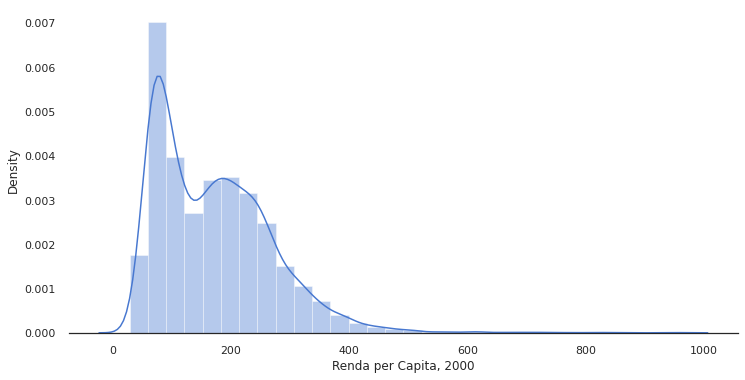

In [59]:
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df['Renda per Capita, 2000'], bins=30)
plt.show();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe990682f90>]],
      dtype=object)

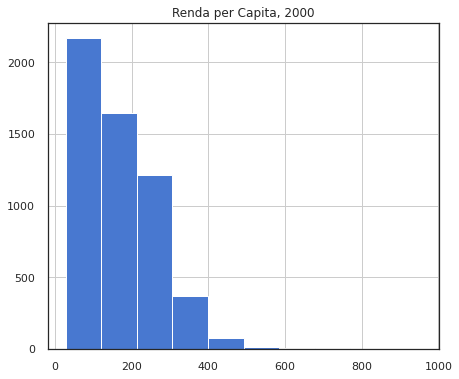

In [60]:
hist_plot(df,'Renda per Capita, 2000',10)

# Identifica-se na distribuição a existencia de 5 grupos:
- Abaixo de 100
- Entre 101 e 200
- Entre 201 e 300
- Entre 300 e 400
- Acima de 400

In [61]:
renda = np.where((df['Renda per Capita, 2000'] > 0) & (df['Renda per Capita, 2000'] <100), "Abaixo de 100", 
                    np.where((df['Renda per Capita, 2000'] > 101) & (df['Renda per Capita, 2000'] <=200), "Entre 100 e 200",
                             np.where((df['Renda per Capita, 2000'] > 200) & (df['Renda per Capita, 2000'] <=300), "Entre 201 e 300",
                                      np.where((df['Renda per Capita, 2000'] > 300) & (df['Renda per Capita, 2000'] <= 400), "Entre 300 e 400",
                                               np.where((df['Renda per Capita, 2000'] > 400), "Acima de 400",'Abaixo de 100')))))

In [62]:
df['Faixa_renda'] = renda

# Distribuição da distância da cidade até a capital.

---



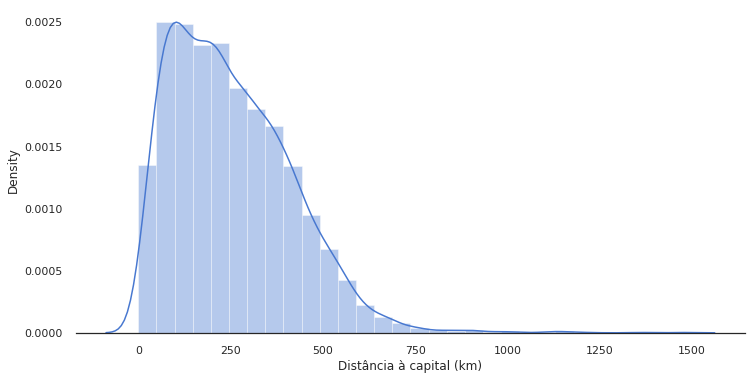

In [63]:
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df['Distância à capital (km)'], bins=30)
plt.show();

In [64]:
df['Distância à capital (km)'].describe()

count    5507.000000
mean      253.212620
std       163.210532
min         0.000000
25%       121.858906
50%       228.262939
75%       358.072044
max      1474.314590
Name: Distância à capital (km), dtype: float64

In [65]:
distancia_capital = np.where((df['Distância à capital (km)'] > 0) & (df['Distância à capital (km)'] <121), "Abaixo de 120 km", 
                    np.where((df['Distância à capital (km)'] > 121) & (df['Distância à capital (km)'] <228), "Entre 121 e 228",
                             np.where((df['Distância à capital (km)'] > 228) & (df['Distância à capital (km)'] <358), "Entre 228 e 358",
                                      np.where(df['Distância à capital (km)'] > 358, 'Acima de 358', 'Abaixo de 120'))))

In [66]:
df['Distancia_capital'] = distancia_capital

In [67]:
df[['Município', 'Distância à capital (km)', 'Distancia_capital']]

,Município,Distância à capital (km),Distancia_capital
0,Jutaí,749.232205,Acima de 358
1,São Gabriel da Cachoeira,851.225150,Acima de 358
2,Formosa do Rio Preto,756.981922,Acima de 358
3,Miranda,181.846641,Entre 121 e 228
4,Santa Vitória do Palmar,436.821147,Acima de 358
...,...,...,...
5502,São José do Hortêncio,56.152137,Abaixo de 120 km
5503,Vila Flores,133.275166,Entre 121 e 228
5504,Lindolfo Collor,48.490606,Abaixo de 120 km
5505,Barra do Choça,307.875581,Entre 228 e 358


In [68]:
df

,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000",...,"Taxa bruta de freqüência à escola, 2000","Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 2000","População total, 2000","População urbana, 2000","População rural, 2000",Faixa_renda,Distancia_capital
0,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,...,51.33,54.90,2.08,6210,466,22500,7725,14775,Abaixo de 100,Acima de 358
1,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,...,68.38,76.85,3.90,11783,1096,29947,12373,17574,Entre 100 e 200,Acima de 358
2,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,...,79.18,67.70,2.90,6935,777,18288,9381,8907,Entre 100 e 200,Acima de 358
3,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,...,76.35,83.40,4.15,10601,1141,23007,12059,10948,Entre 201 e 300,Entre 121 e 228
4,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,...,85.84,91.11,5.70,18638,2605,33304,27952,5352,Acima de 400,Acima de 358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,250.83,...,71.58,97.31,5.14,2043,296,3387,2093,1294,Entre 201 e 300,Abaixo de 120 km
5503,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,246.57,...,86.00,94.81,5.31,1901,285,3086,1045,2041,Entre 201 e 300,Entre 121 e 228
5504,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,240.11,...,72.43,95.62,4.74,2255,173,4414,3418,996,Entre 201 e 300,Abaixo de 120 km
5505,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,71.75,...,75.63,64.33,1.75,17090,1693,40818,17721,23097,Abaixo de 100,Entre 228 e 358


## Quantidade de clusters para Renda per Capita

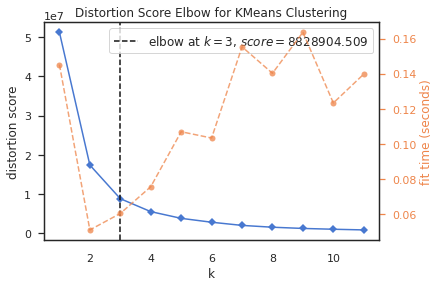

In [69]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
X = df['Renda per Capita, 2000'].values.reshape(-1,1)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof() ;   # Draw/show/poof the data

## Quantidade de clusters para Distancia a capital

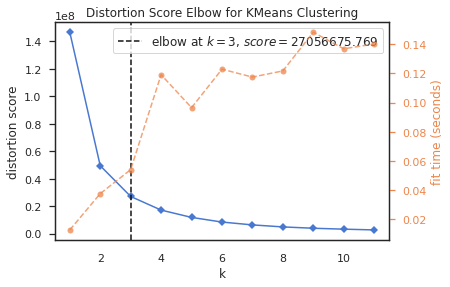

In [70]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
X = df['Distância à capital (km)'].values.reshape(-1,1)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof();    # Draw/show/poof the data

## Identificar pelo metodo de Elbow o numero de cluster pela Renda per Capita

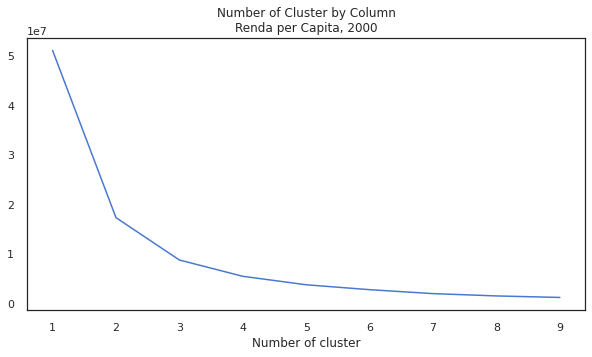

In [71]:
number_of_cluster('Renda per Capita, 2000')

In [72]:
create_cluster(df,'Renda per Capita, 2000', 'Cluster_Renda' )

In [73]:
df

,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000",...,"Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 2000","População total, 2000","População urbana, 2000","População rural, 2000",Faixa_renda,Distancia_capital,Cluster_Renda
0,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,...,54.90,2.08,6210,466,22500,7725,14775,Abaixo de 100,Acima de 358,1
1,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,...,76.85,3.90,11783,1096,29947,12373,17574,Entre 100 e 200,Acima de 358,1
2,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,...,67.70,2.90,6935,777,18288,9381,8907,Entre 100 e 200,Acima de 358,1
3,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,...,83.40,4.15,10601,1141,23007,12059,10948,Entre 201 e 300,Entre 121 e 228,2
4,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,...,91.11,5.70,18638,2605,33304,27952,5352,Acima de 400,Acima de 358,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,250.83,...,97.31,5.14,2043,296,3387,2093,1294,Entre 201 e 300,Abaixo de 120 km,2
5503,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,246.57,...,94.81,5.31,1901,285,3086,1045,2041,Entre 201 e 300,Entre 121 e 228,2
5504,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,240.11,...,95.62,4.74,2255,173,4414,3418,996,Entre 201 e 300,Abaixo de 120 km,2
5505,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,71.75,...,64.33,1.75,17090,1693,40818,17721,23097,Abaixo de 100,Entre 228 e 358,1


In [74]:
df[['Renda per Capita, 2000', 'Cluster_Renda', 'Faixa_renda']]

,"Renda per Capita, 2000",Cluster_Renda,Faixa_renda
0,60.79,1,Abaixo de 100
1,106.61,1,Entre 100 e 200
2,117.52,1,Entre 100 e 200
3,248.19,2,Entre 201 e 300
4,406.43,0,Acima de 400
...,...,...,...
5502,250.83,2,Entre 201 e 300
5503,246.57,2,Entre 201 e 300
5504,240.11,2,Entre 201 e 300
5505,71.75,1,Abaixo de 100


## Identificar pelo metodo de Elbow o numero de cluster pela Distancia a Capital

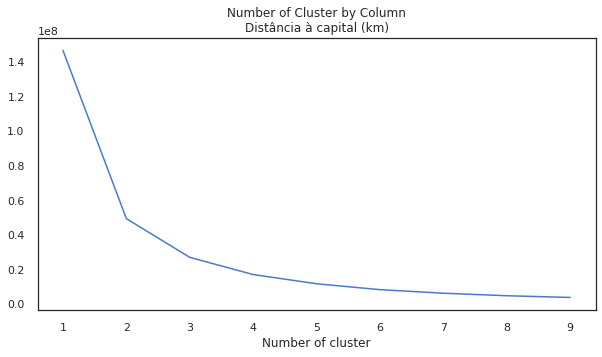

In [75]:
number_of_cluster('Distância à capital (km)')

In [76]:
create_cluster(df,'Distância à capital (km)', 'Cluster_Distancia' )

In [77]:
df

,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000",...,"Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 2000","População total, 2000","População urbana, 2000","População rural, 2000",Faixa_renda,Distancia_capital,Cluster_Renda,Cluster_Distancia
0,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,...,2.08,6210,466,22500,7725,14775,Abaixo de 100,Acima de 358,1,1
1,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,...,3.90,11783,1096,29947,12373,17574,Entre 100 e 200,Acima de 358,1,1
2,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,...,2.90,6935,777,18288,9381,8907,Entre 100 e 200,Acima de 358,1,1
3,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,...,4.15,10601,1141,23007,12059,10948,Entre 201 e 300,Entre 121 e 228,2,2
4,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,...,5.70,18638,2605,33304,27952,5352,Acima de 400,Acima de 358,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,250.83,...,5.14,2043,296,3387,2093,1294,Entre 201 e 300,Abaixo de 120 km,2,2
5503,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,246.57,...,5.31,1901,285,3086,1045,2041,Entre 201 e 300,Entre 121 e 228,2,2
5504,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,240.11,...,4.74,2255,173,4414,3418,996,Entre 201 e 300,Abaixo de 120 km,2,2
5505,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,71.75,...,1.75,17090,1693,40818,17721,23097,Abaixo de 100,Entre 228 e 358,1,0


In [78]:
df[['Distância à capital (km)', 'Cluster_Distancia','Distancia_capital']]

,Distância à capital (km),Cluster_Distancia,Distancia_capital
0,749.232205,1,Acima de 358
1,851.225150,1,Acima de 358
2,756.981922,1,Acima de 358
3,181.846641,2,Entre 121 e 228
4,436.821147,1,Acima de 358
...,...,...,...
5502,56.152137,2,Abaixo de 120 km
5503,133.275166,2,Entre 121 e 228
5504,48.490606,2,Abaixo de 120 km
5505,307.875581,0,Entre 228 e 358


In [79]:
df.Cluster_Distancia.value_counts()

2    2429
0    2099
1     979
Name: Cluster_Distancia, dtype: int64

In [80]:
df.Cluster_Renda.value_counts()

1    2611
2    2215
0     681
Name: Cluster_Renda, dtype: int64

In [81]:
df[['Município', 'Cluster_Renda', "Faixa_renda", 'Cluster_Distancia', 'Distancia_capital']]

,Município,Cluster_Renda,Faixa_renda,Cluster_Distancia,Distancia_capital
0,Jutaí,1,Abaixo de 100,1,Acima de 358
1,São Gabriel da Cachoeira,1,Entre 100 e 200,1,Acima de 358
2,Formosa do Rio Preto,1,Entre 100 e 200,1,Acima de 358
3,Miranda,2,Entre 201 e 300,2,Entre 121 e 228
4,Santa Vitória do Palmar,0,Acima de 400,1,Acima de 358
...,...,...,...,...,...
5502,São José do Hortêncio,2,Entre 201 e 300,2,Abaixo de 120 km
5503,Vila Flores,2,Entre 201 e 300,2,Entre 121 e 228
5504,Lindolfo Collor,2,Entre 201 e 300,2,Abaixo de 120 km
5505,Barra do Choça,1,Abaixo de 100,0,Entre 228 e 358
